In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib.pyplot as plt

In [60]:
from utils import play
from qlearner import QPlayer
from tic_env import OptimalPlayer
import random

# Fix seed for reproducibility
random.seed(0)

In [58]:
import matplotlib.pyplot as plt


def plot_average_stats(players, log_every=250, labels=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    for i, player in enumerate(players):
        if labels is not None:
            label = labels[i]
        else:
            label = None if callable(player.epsilon) else f"$\epsilon$={player.epsilon}"
        game_ids = list(range(len(player.avg_losses)))
        ax.plot(game_ids, player.avg_rewards, label=label)
    
    ax.set_title(f'Average reward per {log_every} games', fontsize=20, fontweight='bold')
    ax.set_xlabel('Game', fontsize=16)
    ax.set_ylabel('Reward', fontsize=16)
    ax.set_xlim([0, len(game_ids)])
    ax.legend(loc='lower right')
    ax.grid()

    plt.show()

### Q1

In [63]:
epsilons = [0.01, 0.1]
eps_q_players = []

for eps in epsilons:
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=eps, log_every=250)
    play(suboptimal_player, q_player, episodes=20000)
    eps_q_players.append(q_player)

  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

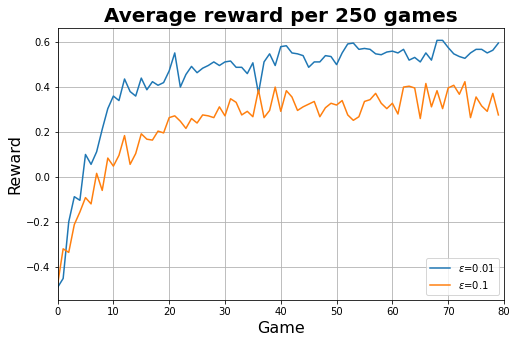

In [59]:
plot_average_stats(eps_q_players)

### Q2

In [65]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_stars = [1, 100, 1000, 10000, 40000]
n_star_players = []
get_epsilon = lambda n: max(EPS_MIN, EPS_MAX * (1 - n / n_star))

for n_star in n_stars:
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=get_epsilon, log_every=250)
    play(suboptimal_player, q_player, episodes=20000)
    n_star_players.append(q_player)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


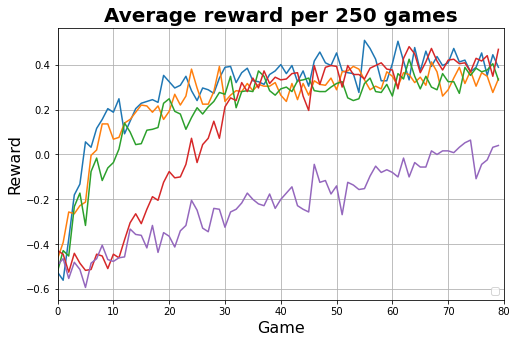

In [67]:
plot_average_stats(n_star_players)

### Q3

In [68]:
def plot_m_values(players, test_every=250, labels=None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, player in enumerate(players):
        if labels is not None:
            label = labels[i]
        else:
            label = None if callable(player.epsilon) else f"eps={player.epsilon}"
        game_ids = list(range(len(player.m_values["m_opt"])))
        axes[0].plot(game_ids, player.m_values["m_opt"], label=label)
        axes[1].plot(game_ids, player.m_values["m_rand"], label=label)

        
    axes[0].set_title(f'M_opt per {test_every} games', fontsize=20, fontweight='bold')
    axes[0].set_xlabel('Game', fontsize=16)
    axes[0].set_ylabel('M_opt', fontsize=16)
    axes[0].set_xlim([0, len(game_ids)])
    axes[0].legend()
    axes[1].grid()
    
    axes[1].set_title(f'M_rand per {test_every} games', fontsize=20, fontweight='bold')
    axes[1].set_xlabel('Game', fontsize=16)
    axes[1].set_ylabel('M_rand', fontsize=16)
    axes[0].set_xlim([0, len(game_ids)])
    axes[1].legend()
    axes[1].grid()

    plt.legend()
    plt.show()

In [69]:
EPS_MIN = 0.1
EPS_MAX = 0.8
n_stars = [1, 100, 1000, 10000, 40000]
n_star_players = []
get_epsilon = lambda n: max(EPS_MIN, EPS_MAX * (1 - n / n_star))

for n_star in n_stars:
    suboptimal_player = OptimalPlayer(epsilon=0.5)
    q_player = QPlayer(epsilon=get_epsilon, log_every=250, test_every=250)
    play(suboptimal_player, q_player, episodes=20000)
    n_star_players.append(q_player)

  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 